# *IT00CH92 Embedded AI - Spring 2024*



# Training MNIST using TensorFlow

## Overview

To effectively deploy deep neural models on resource-constrained edge devices, two critical aspects of model optimization are most useful: pruning, which involves reducing the size of a neural network by eliminating unnecessary parameters, and quantization, which involves reducing the precision of numerical values in the model to conserve memory and computational resources.

For using these techniques, we define the application area by employing the popular LeNet-5 architecture trained on the classic MNIST dataset. LeNet-5, designed by Yann LeCun et al., represents one of the pioneering convolutional neural network (CNN) architectures and remains a benchmark for image classification tasks. At the end of the notebook, we obtain the trained full-precision model to be used for the further steps of the project.

Edit: The LeNet-5 model is trained with the parameters (epochs = 10, batch size = 64) from https://www.educative.io/blog/lenet-5 

## Setup

In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras

# import tf_keras as keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.random.set_seed(
    seed=81
)

2024-05-21 15:07:09.308216: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 15:07:09.342296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:07:09.342329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:07:09.343596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 15:07:09.349728: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 15:07:09.350227: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Using Tensorflow Datasets API to load MNIST

TFDS datasets often come with data already split into different sets. For MNIST, it has splits for train and test. We use the [Slicing API](https://www.tensorflow.org/datasets/splits#slicing_api) for TFDS to create a validation split.

Next, we aim to understand how the dataset is formatted and utilize visualizations. Finally, the dataset is preprocessed before being passed to the model. For preprocessing, we simply normalize the image values as float32 within the range [0, 1] for all three splits.

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2024-05-21 15:07:11.265665: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 15:07:11.266264: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2024-05-21 15:07:11.441843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Input image shape: (28, 28, 1)
Image type: <dtype: 'uint8'>
Label shape: ()
Label type: <dtype: 'int64'>


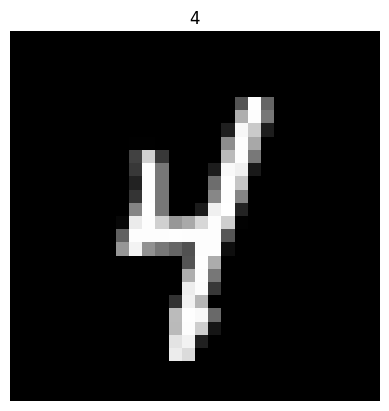

In [3]:
ds = ds_train.take(1)  # Only take a single example
for example in ds:  # example is `('image': tf.Tensor, 'label': tf.Tensor)`
  image = example[0]
  label = example[1]
  print(f"Input image shape: {image.shape}\nImage type: {image.dtype}")
  print(f"Label shape: {label.shape}\nLabel type: {label.dtype}")
  plt.imshow(image, cmap='gray')
  plt.title(label.numpy())
  plt.axis("off")
  plt.show()

2024-05-21 15:07:11.679890: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


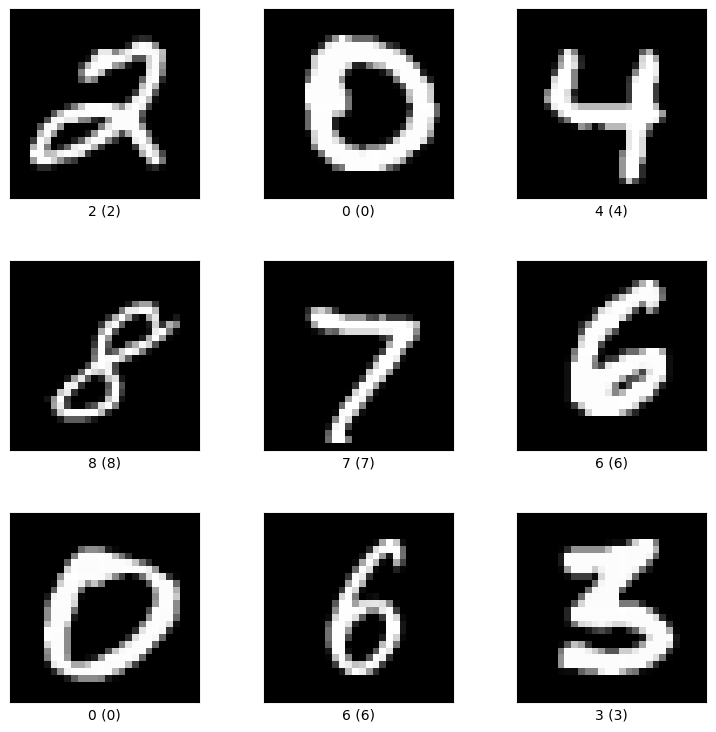

In [4]:
fig = tfds.show_examples(ds_test, ds_info)

### Parameters

In [5]:
# batch_size = 128
# n_epochs = 4
batch_size = 64
n_epochs = 10

### Preprocessing

In [6]:
def normalize_img(image:tf.uint8, label:tf.int64):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def normalize_splits(ds, split_name: str, batch_size: int):
  """Applies preprocessing to train, val and test sets"""
  ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
  )
  ds = ds.cache() # Caching makes it faster for consecutive runs
  if split_name != 'test':
    # Shuffling is not done for the test set
    ds = ds.shuffle(ds_info.splits[split_name].num_examples)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [7]:
ds_train = normalize_splits(ds_train, split_name='train[:90%]', batch_size=batch_size)
ds_val = normalize_splits(ds_val, split_name='train[90%:]', batch_size=batch_size)
ds_test = normalize_splits(ds_test, split_name='test', batch_size=batch_size)

## Training Neural Network

In [8]:
# Define the model architecture (LeNet-5).

model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(120,activation='relu'),
  keras.layers.Dense(84,activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])

# As truth labels are integer encoded, we use sparse categorical cross-entropy as loss fn
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # the ouputs are expected as probabilities
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 120)               9

Fit model and evaluate its accuracy on test set

In [9]:
history = model.fit(
  ds_train,
  epochs=n_epochs,
  validation_data=ds_val,
)

Epoch 1/10
844/844 [==============================] - 10s 8ms/step - loss: 0.2273 - accuracy: 0.9298 - val_loss: 0.0832 - val_accuracy: 0.9762
Epoch 2/10
844/844 [==============================] - 6s 7ms/step - loss: 0.0663 - accuracy: 0.9794 - val_loss: 0.0577 - val_accuracy: 0.9825
Epoch 3/10
844/844 [==============================] - 7s 8ms/step - loss: 0.0471 - accuracy: 0.9847 - val_loss: 0.0682 - val_accuracy: 0.9793
Epoch 4/10
844/844 [==============================] - 6s 7ms/step - loss: 0.0387 - accuracy: 0.9872 - val_loss: 0.0522 - val_accuracy: 0.9833
Epoch 5/10
844/844 [==============================] - 6s 7ms/step - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.0465 - val_accuracy: 0.9848
Epoch 6/10
844/844 [==============================] - 6s 7ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.0505 - val_accuracy: 0.9832
Epoch 7/10
844/844 [==============================] - 7s 7ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0414 - val_accuracy: 0.9882
Epoch

The constructed model is trained using the training data with a portion reserved for validation. The training process is visualized by plotting training and validation accuracy and loss over epochs.

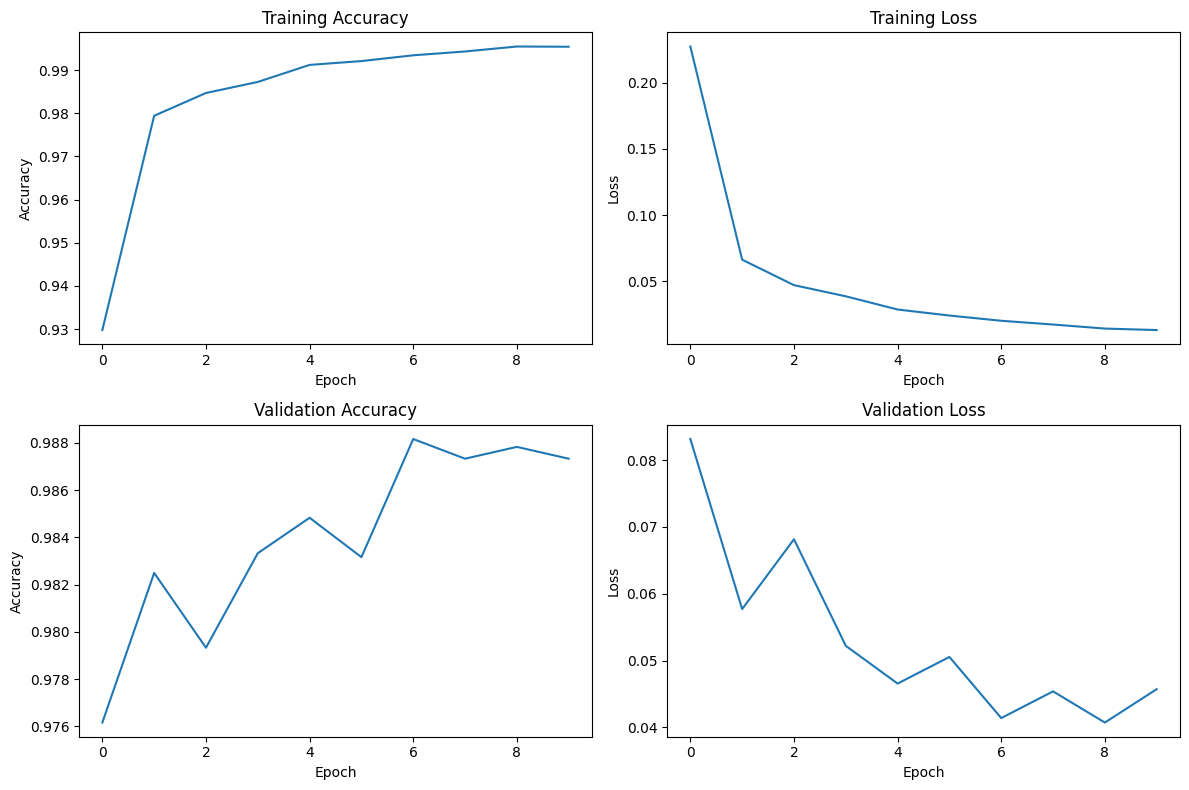

In [10]:
# Visualize training plot
plt.figure(figsize=(12, 8))

# Plot training accuracy values
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot validation accuracy values
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot validation loss values
plt.subplot(2, 2, 4)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [11]:
_, baseline_accuracy = model.evaluate(
    ds_test, verbose=0)

print('Baseline test accuracy:', baseline_accuracy)

Baseline test accuracy: 0.9890000224113464


Export model to `saved_model/` dir

In [12]:
base_model_file = './saved_model/Full_Precision_MNIST.h5' # Trained with tfds
# Saving the model in .h5 format
keras.models.save_model(model, base_model_file, include_optimizer=False)

/tmp/ipykernel_49443/4114457829.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, base_model_file, include_optimizer=False)


## Fine-tune pre-trained model with pruning

We will apply pruning to the whole model and see this in the model summary.
In this example, we start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity.

In [13]:
import tensorflow_model_optimization as tfmot
# import tensorflow.models.model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 4 epochs.
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = ds_info.splits['train'].num_examples * (1 - validation_split) # trained with tensorflow_datasets
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 6)         308       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 6)         1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 14, 14, 16)        4818      
 _1 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 7, 7, 16)          1         
 oling2d_1 (PruneLowMagnitu                                      
 de)                                                    

### Train and evaluate the model against baseline

Fine tune with pruning for two epochs.

`tfmot.sparsity.keras.UpdatePruningStep` is required during training, and `tfmot.sparsity.keras.PruningSummaries` provides logs for tracking progress and debugging.

In [14]:
# import tempfile

logdir = './logs'

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit( ds_train, ## train with tensorflow_datasets
                       epochs=epochs,
                      #  batch_size=batch_size, validation_split=validation_split,
                       validation_data=ds_val, 
                       callbacks=callbacks)

Epoch 1/2
  1/844 [..............................] - ETA: 32:27 - loss: 0.0092 - accuracy: 1.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0061s vs `on_train_batch_end` time: 0.0082s). Check your callbacks.


844/844 [==============================] - 9s 8ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0440 - val_accuracy: 0.9858
Epoch 2/2
844/844 [==============================] - 7s 8ms/step - loss: 0.0235 - accuracy: 0.9927 - val_loss: 0.0346 - val_accuracy: 0.9877


For this example, there is minimal loss in test accuracy after pruning, compared to the baseline.

In [15]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(ds_test, verbose=0) ## Trained with tfds

print('Baseline test accuracy:', baseline_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9890000224113464
Pruned test accuracy: 0.9900000095367432


### Create 3x smaller models from pruning

Both [`tfmot.sparsity.keras.strip_pruning`](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/strip_pruning) and applying a standard compression algorithm (e.g. via `gzip`) are necessary to see the compression benefits of pruning.

- `strip_pruning` is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to model size during inference
- Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is added redundancy that algorithms can utilize to further compress the model.

First, create a compressible model for TensorFlow.


In [16]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

pruned_keras_file = './saved_model/Pruned_keras_MNIST.h5'
keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

/tmp/ipykernel_49443/2352412401.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)


Saved pruned Keras model to: ./saved_model/Pruned_keras_MNIST.h5


Then, create a compressible model for TFLite.

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

pruned_tflite_file = './saved_model/Pruned_MNIST_TF.tflite'

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpcwreovbv/assets


INFO:tensorflow:Assets written to: /tmp/tmpcwreovbv/assets


Saved pruned TFLite model to: ./saved_model/Pruned_MNIST_TF.tflite


2024-05-21 15:08:39.588931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-21 15:08:39.588957: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-21 15:08:39.589183: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcwreovbv
2024-05-21 15:08:39.590103: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-21 15:08:39.590116: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpcwreovbv
2024-05-21 15:08:39.592270: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-05-21 15:08:39.592821: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-21 15:08:39.608104: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpcwreovbv
2024-05

Define a helper function to actually compress the models via gzip and measure the zipped size.

In [18]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  zipped_file = file+'.zip'
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

Compare and see that the models are 3x smaller from pruning.

In [19]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(base_model_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 403742.00 bytes
Size of gzipped pruned Keras model: 130835.00 bytes
Size of gzipped pruned TFlite model: 125922.00 bytes


## Create a 10x smaller model from combining pruning and quantization
You can apply post-training quantization to the pruned model for additional benefits.
Here we implement full integer quantization from the Tensorflow lite [model optimization instruction](https://www.tensorflow.org/lite/performance/post_training_quantization?authuser=1#full_integer_quantization)

In [20]:
def representative_data_gen():
  for input_value in ds_train.take(1): # take only one batch
    yield [input_value[0]] # input_value is a tuple of (batch-size, image, label)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

int_quantized_tflite_model = converter.convert()

int_quantized_tflite_model_file = './saved_model/int_quantized_pruned_MNIST.tflite'

with open(int_quantized_tflite_model_file, 'wb') as f:
  f.write(int_quantized_tflite_model)

print('Saved full-integer quantized and float fall-back TFLite model to', int_quantized_tflite_model_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(base_model_file)))
print("Size of gzipped pruned and full-integer quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(int_quantized_tflite_model_file)))

INFO:tensorflow:Assets written to: /tmp/tmpnu7wonf1/assets


INFO:tensorflow:Assets written to: /tmp/tmpnu7wonf1/assets
/home/minh/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-21 15:08:40.211569: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-21 15:08:40.211593: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-21 15:08:40.211731: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnu7wonf1
2024-05-21 15:08:40.212828: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-21 15:08:40.212851: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpnu7wonf1
2024-05-21 15:08:40.215904: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-21 15:08:40.2

Saved full-integer quantized and float fall-back TFLite model to ./saved_model/int_quantized_pruned_MNIST.tflite
Size of gzipped baseline Keras model: 403742.00 bytes
Size of gzipped pruned and full-integer quantized TFlite model: 38054.00 bytes


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


### Evaluate the TFLite model on test dataset

Fetch images from all batches of ds_test

In [21]:
test_images = ds_test.unbatch()
dataset_length = len(list(test_images))

print(f"Dataset length: {dataset_length}")


Dataset length: 10000


In [22]:
image_data = []
label_data = []

for images, labels in test_images:
  image_data.append(images)
  label_data.append(labels)

print(f"Image data shape: {image_data[0].shape}")
print(f"data_label shape: {label_data[0].shape}")

Image data shape: (28, 28, 1)
data_label shape: ()


Now we'll compare the performance of the pruned model and quantized model:
+ `pruned_tflite_file` is the path to the model converted with polynomial-decay pruning (it uses float32 data for input and output).
+ `int_quantized_tflite_model_file` is the path to the model converted with integer-only quantization (it uses uint8 data for input and output).

Let's create another function to print our predictions:

In [23]:
# Helper function to run inference on a single image
def run_tflite_model(tflite_file, test_image_data):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Check if the input type is quantized, then rescale input data to uint8
  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details["quantization"]
    test_image_data = test_image_data / input_scale + input_zero_point

  test_image_data = np.expand_dims(test_image_data, axis=0).astype(input_details["dtype"])
  interpreter.set_tensor(input_details["index"], test_image_data)
  interpreter.invoke()
  output = interpreter.tensor(output_details["index"])
  
  prediction = np.argmax(output()[0])

  return prediction


In [24]:
import matplotlib.pylab as plt

# Change the following to test a different image
test_image_index = 10

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global image_data, label_data
  test_image_data = image_data[test_image_index]
  test_label = label_data[test_image_index]
  prediction = run_tflite_model(tflite_file, test_image_data)
  # print test image and the prediction
  print("Test image data : ", test_image_data)
  plt.imshow(test_image_data, cmap='gray')
  plt.axis('off')
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true=str(test_label), predict=str(prediction)))
  plt.grid(False)

Now test the pruned model:

Test image data :  tf.Tensor(
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


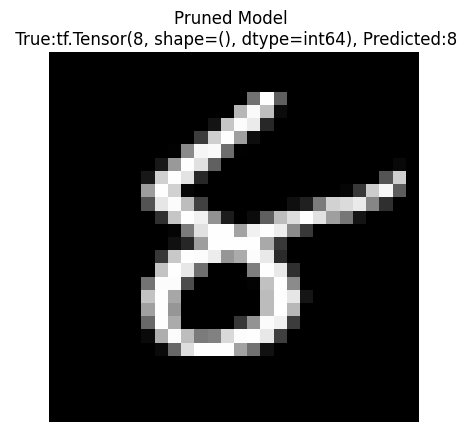

In [25]:
test_model(pruned_tflite_file, test_image_index, model_type="Pruned")

And test the quantized model:

Test image data :  tf.Tensor(
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

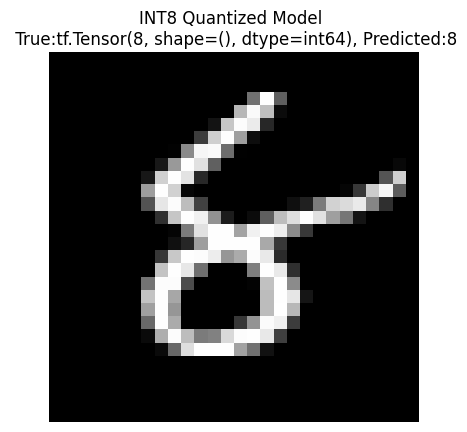

In [26]:
test_model(int_quantized_tflite_model_file, test_image_index, model_type="INT8 Quantized")

Helper function for model evaluation

In [27]:
# A helper function to evaluate the TF Lite model using "test" dataset.

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  
  input_dtype = interpreter.get_input_details()[0]['dtype']
  input_scale, input_zero_point = interpreter.get_input_details()[0]['quantization']
  
  # Run predictions on ever y image in the ds_test dataset.
  prediction_digits = []
  for i, test_image in enumerate(image_data):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    
    # Pre-processing: rescale the input data with the quantization parameters
    if(input_dtype == np.uint8):
      test_image = test_image / input_scale + input_zero_point
    # Pre-processing: flattening the np.array and convertthe data type of input tensor to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(input_dtype)
    interpreter.set_tensor(input_index, test_image)
    
    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)
    
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == label_data).mean()
  return accuracy


Create model interpreters and evaluate their accuracy

In [28]:
interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)
interpreter.allocate_tensors()

interpreter_quant = tf.lite.Interpreter(model_content=int_quantized_tflite_model)
interpreter_quant.allocate_tensors()

pruned_accuracy = evaluate_model(interpreter)
int_quantized_accuracy = evaluate_model(interpreter_quant)

print("Pruned model accuracy: ", pruned_accuracy)
print("full-integer Quantized and pruned model accuracy: ", int_quantized_accuracy)


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Pruned model accuracy:  0.99
full-integer Quantized and pruned model accuracy:  0.9897


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [29]:
# !apt-get -qq install xxd ## Install xxd if it is not available
!echo "#ifndef TFLITE_INT_QUANTIZED_PRUNED_MNIST_MODEL_DATA_H_" >> ./saved_model/MNIST_quantized_int8_test.h
!echo "#define TFLITE_INT_QUANTIZED_PRUNED_MNIST_MODEL_DATA_H_" >> ./saved_model/MNIST_quantized_int8_test.h
!echo "extern const unsigned char g_model_data[];" >>  ./saved_model/MNIST_quantized_int8_test.h
!echo "extern const int g_model_data_len;" >>  ./saved_model/MNIST_quantized_int8_test.h
!echo "#endif  // TFLITE_INT_QUANTIZED_PRUNED_MNIST_MODEL_DATA_H_" >> ./saved_model/MNIST_quantized_int8_test.h

!echo "#include \"MNIST_quantized_int8_test.h\"" >> ./saved_model/MNIST_quantized_int8_test.cpp
!echo "alignas(16) const unsigned char g_model_data[] = {" >> ./saved_model/MNIST_quantized_int8_test.cpp
!cat ./saved_model/int_quantized_pruned_MNIST.tflite | xxd -i      >> ./saved_model/MNIST_quantized_int8_test.cpp
!echo "};"                              >> ./saved_model/MNIST_quantized_int8_test.cpp

import os
model_int_size = os.path.getsize("./saved_model/MNIST_quantized_int8_test.cpp")
print(f"Model file, MNIST_quantized_int8_test.cpp, is {model_int_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Model file, MNIST_quantized_int8_test.cpp, is 701,958 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


### Test with hand-drawn samples

To validate the perfomance, we test the quantized model with our own hand-drawn digit (inside `test_inputs` dir)

Input dtype =  <class 'numpy.uint8'>
Output dtype =  <class 'numpy.uint8'>
Input scale =  0.003921568859368563
Input zero point =  0
Quantized test image =  [[[[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  1]
   [  1]
   [  1]
   [  1]
   [  1]
   [ 20]
   [ 25]
   [ 25]
   [ 23]
   [  3]
   [  1]
   [  1]
   [  1]
   [  1]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]
   [  0]


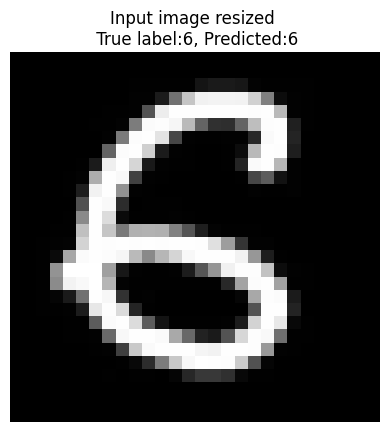

In [30]:
import cv2

# Load the test image
target_size = (28, 28)
image_path = "./test_inputs/sample_6.jpg"

input_image = cv2.imread(image_path)
test_input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
test_input_image = cv2.resize(test_input_image, target_size, interpolation=cv2.INTER_AREA)

normalized_test_input_image = (test_input_image / 255.0).astype(np.float32)

# Initialize the interpreter
interpreter_quant = tf.lite.Interpreter(model_path=str(int_quantized_tflite_model_file))
interpreter_quant.allocate_tensors()

input_index = interpreter_quant.get_input_details()[0]["index"]
output_index = interpreter_quant.get_output_details()[0]["index"]

input_details = interpreter_quant.get_input_details()[0]
output_details = interpreter_quant.get_output_details()[0]

# input type is quantized, thus we rescale input data with quantization parameters
print("Input dtype = ", input_details['dtype'])
print("Output dtype = ", output_details['dtype'])

input_scale, input_zero_point = input_details["quantization"]
print("Input scale = ", input_scale)
print("Input zero point = ", input_zero_point)
quantized_image = np.expand_dims(normalized_test_input_image / input_scale + input_zero_point, axis=(0,3)).astype(input_details["dtype"])

print("Quantized test image = ", quantized_image)
print("Quantized test image shape = ", quantized_image.shape)

# Set the input tensor
interpreter_quant.set_tensor(input_index, quantized_image)

interpreter_quant.invoke()
output = interpreter_quant.tensor(output_index)

print("Output tensor = ", output())
prediction = np.argmax(output()[0])
# prediction = output()
print(f"Prediction: {prediction}")

template = "Input image resized \n True label:{true}, Predicted:{predict}"
plt.imshow(test_input_image, cmap='gray')
_ = plt.title(template.format(true=str(6), predict=str(prediction)))
plt.axis("off")
plt.show()


## Conclusion

In this notebook, we trained a LeNet-5 neural network on the MNIST dataset using TensorFlow (and various of its APIs). It's important to note the size of the trained model in terms of the number of trainable parameters and the baseline test accuracy for further comparisons during the pruning and quantization steps.

**added from tutorial**:  
In this tutorial, you saw how to create sparse models with the TensorFlow Model Optimization Toolkit API for both TensorFlow and TFLite. You then combined pruning with post-training quantization for additional benefits.

Hence, we created a 10x smaller model for MNIST by implementing polynomial-decay pruning combined with full-integer quantization, the resulted model has minimal accuracy loss.

The evaluation results show that the quantized model achieve comparable accuracy to the pruned model and the base model.